# Plot AMOC #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import pandas as pd
import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes import utils, load_data

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load AMOC data ##

In [3]:
amoc_data = load_data.load_amoc()

## Load GSAT data ##

In [4]:
gsat = load_data.load_gsat()

In [5]:
gwl_years = load_data.load_gwl_years()

### Calculate peak warming years ###

In [6]:
gsat_rolling = {
    model: utils.rolling(ds,21,time_dim='time') for model, ds in gsat.items()
}

peak_years = {
    model: utils.peak_warming(ds) for model, ds in gsat_rolling.items()
}

### Identify Changes at 1.5ºC Warming ###

In [7]:
AMOC_changes = {}
for model in models:
    amoc_series = utils.rolling(amoc_data[model]['anom'],21,time_dim='year')
    std_dev = amoc_data[model]['std_dev'].values
    up15_year = gwl_years[model].sel(branch='ramp_up').sel(gwl=1.5).values
    down15_year = gwl_years[model].sel(branch='ramp_down').sel(gwl=1.5).values
    amoc_15_up = amoc_series.sel(year=up15_year).values
    amoc_15_down = amoc_series.sel(year=down15_year).values
    print(model)
    print(f"change in AMOC strength: {amoc_15_down-amoc_15_up} Sv")
    print(f"piControl std_dev: {std_dev}")
    AMOC_changes[model] = np.round(amoc_15_down - amoc_15_up, 2)
    
AMOC_changes = dict(sorted(AMOC_changes.items(), key=lambda item: item[1]))

ACCESS-ESM1-5
change in AMOC strength: 3.282419068472726 Sv
piControl std_dev: 0.9480735063552856
CanESM5
change in AMOC strength: 3.1064087549845376 Sv
piControl std_dev: 0.826939046382904
CESM2
change in AMOC strength: -4.4692284266153965 Sv
piControl std_dev: 0.8172551989555359
CNRM-ESM2-1
change in AMOC strength: -3.3499855995178223 Sv
piControl std_dev: 2.007047653198242
GFDL-ESM4
change in AMOC strength: 1.9428984324137368 Sv
piControl std_dev: 1.1683980226516724
MIROC-ES2L
change in AMOC strength: -2.3867352349417548 Sv
piControl std_dev: 1.0721344947814941
NorESM2-LM
change in AMOC strength: -1.218859763372512 Sv
piControl std_dev: 0.7849041819572449
UKESM1-0-LL
change in AMOC strength: 1.0694302580410375 Sv
piControl std_dev: 0.9478689432144165


In [8]:
AMOC_changes

{'CESM2': -4.47,
 'CNRM-ESM2-1': -3.35,
 'MIROC-ES2L': -2.39,
 'NorESM2-LM': -1.22,
 'UKESM1-0-LL': 1.07,
 'GFDL-ESM4': 1.94,
 'CanESM5': 3.11,
 'ACCESS-ESM1-5': 3.28}

In [9]:
models_amoc_ordered = list(AMOC_changes.keys())
models_amoc_ordered

['CESM2',
 'CNRM-ESM2-1',
 'MIROC-ES2L',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'GFDL-ESM4',
 'CanESM5',
 'ACCESS-ESM1-5']

## Plot AMOC timeseries ##

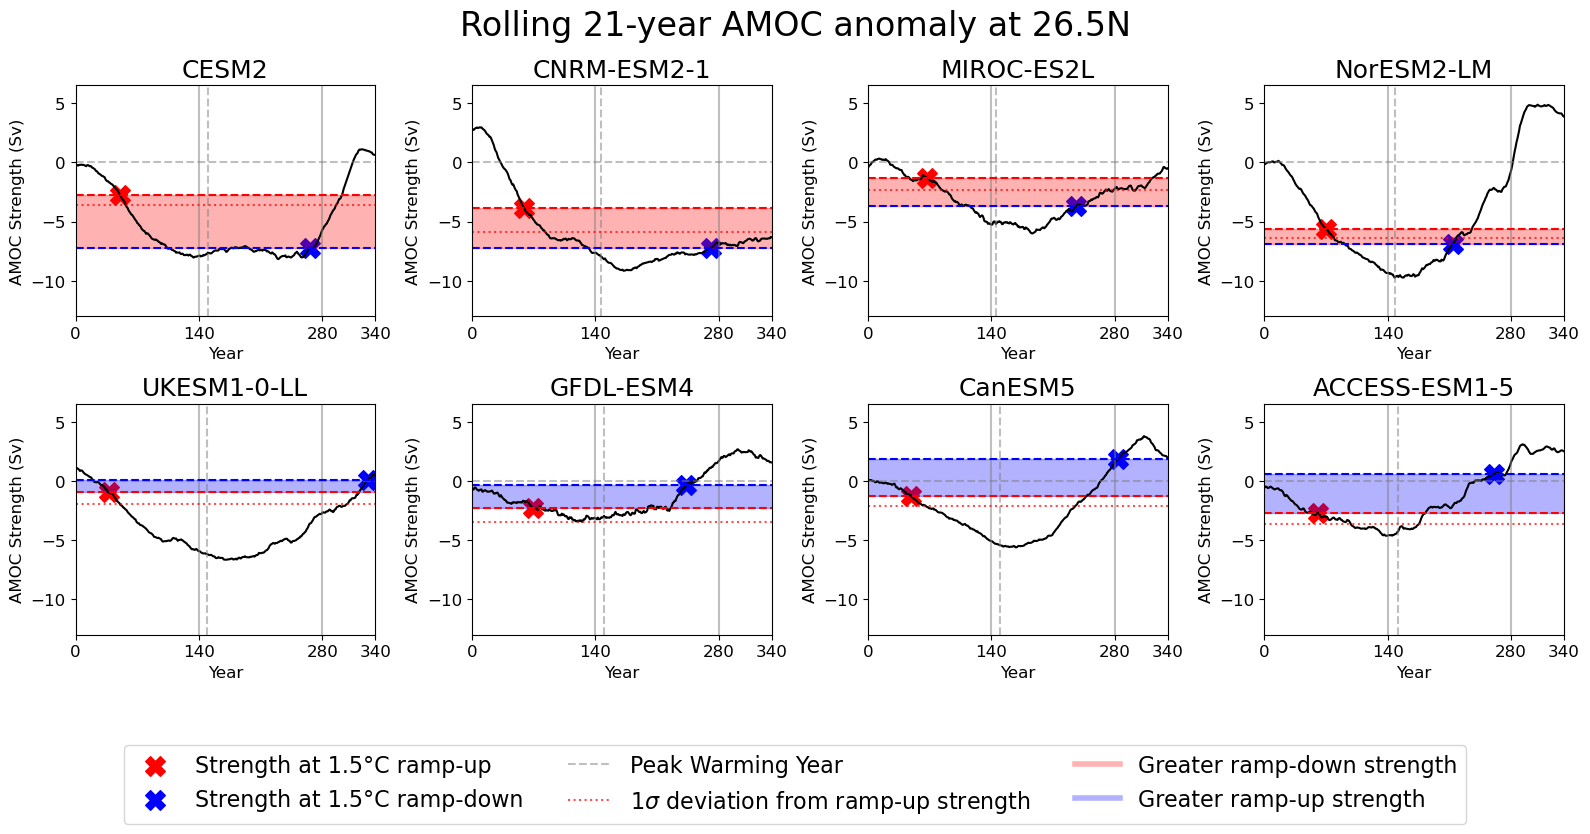

In [10]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(2,4,figsize=(16,7))

for model, ax in zip(models_amoc_ordered,axes.flat):
    
    amoc = utils.rolling(amoc_data[model]['anom'],21,time_dim='year')
    amoc.plot(ax=ax,color='black')

    # plot values at 1.5 degrees
    up15_year = gwl_years[model].sel(branch='ramp_up').sel(gwl=1.5)
    up15_value = amoc.sel(year=up15_year).values
    down15_year = gwl_years[model].sel(branch='ramp_down').sel(gwl=1.5)
    down15_value = amoc.sel(year=down15_year).values

    ax.scatter(up15_year,up15_value,
               marker="X",s=200,
               color='red',
              label='Strength at 1.5°C ramp-up')
    ax.scatter(down15_year,down15_value,
               marker="X",s=200,
               color='blue',
              label='Strength at 1.5°C ramp-down')
    
    # plot peak warming
    ax.axvline(x=peak_years[model][1],linestyle='--',
               label='Peak Warming Year',
               color='grey',alpha=0.5)

    # other important lines
    ax.axvline(x=140,linestyle='-',
               # label='Peak CO$_2$',
               color='grey',alpha=0.5)
    ax.axvline(x=280,linestyle='-',
               # label='Return to PI CO$_2$',
               color='grey',alpha=0.5)
    ax.axhline(y=0,linestyle='--',color='grey',alpha=0.5)

    # plot shading
    std_dev = amoc_data[model]['std_dev']
    ax.axhline(y=up15_value,
               linestyle='--',color='red')
    ax.axhline(y=down15_value,
               linestyle='--',color='blue',)
    ax.axhline(y=up15_value - std_dev,
               linestyle=':',color='red',alpha=0.7,label='1$\sigma$ deviation from ramp-up strength')

    # Fill between the horizontal lines
    lower_y = min(up15_value, down15_value)
    upper_y = max(up15_value, down15_value)
    color = 'blue' if down15_value > up15_value else 'red'
    ax.fill_betweenx([lower_y, upper_y], ax.get_xlim()[0], ax.get_xlim()[1], color=color, alpha=0.3)
    
    ax.set_title(model,fontsize=18)
    ax.set_ylabel('AMOC Strength (Sv)',fontsize=12)
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylim([-13,6.5])
    ax.set_xlim([0,340])
    ax.set_xticks([0,140,280,340])
    ax.set_xticklabels(['0','140','280','340'],fontsize=12)
    ax.tick_params(axis='y',labelsize=12)

# legend

handles, labels = axes[0][0].get_legend_handles_labels()

# Create custom legend entries for the shaded areas
custom_lines = [
    Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Down > Up'),
    Line2D([0], [0], color='blue', lw=4, alpha=0.3, label='Up > Down')
]
# Combine them
handles.extend(custom_lines)
labels.extend(['Greater ramp-down strength', 'Greater ramp-up strength'])

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=16)
# axes[0,3].legend(loc='lower center',bbox_to_anchor=(0.5,-0.1))
fig.suptitle('Rolling 21-year AMOC anomaly at 26.5N',fontsize=24)
fig.tight_layout()